# Fit an Ising model to the odor mixture presence/absence data that we have
using methods described in Broderick et al. 2007 
https://arxiv.org/abs/0712.2437

In [60]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, value_and_grad, jit, vmap, lax, jit, tree_util, nn
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.ndimage import maximum_filter
import matplotlib.colors as mcolors
import numpy as np

In [61]:
DATA_PATH = '../vcf/Matrix2.csv'

In [62]:
class OlfactionIsingModel:
    def __init__(self, data_path, key, fraction=1, shuffle=False):
        # Static attributes
        self.data_path = data_path
        self.key = key
        self.fraction = fraction
        self.shuffle = shuffle 
        self.data = self.load_data(key, fraction, shuffle) 
        # Compute derived attributes
        self.empirical_mean, self.empirical_cov = self.set_empirical_means()

        # Dynamic attributes (initialized later)
        self.beta = None
        self.h = None
        self.J = None
        self.burnin = None
        self.tau = None

    def set_parameters(self, beta, h, J, burnin, tau):
        self.beta = beta
        self.h = h
        self.J = J
        self.burnin = burnin
        self.tau = tau

    def _tree_flatten(self):
        children = (self.beta, self.h, self.J, self.burnin, self.tau)
        aux_data = {
            'data_path': self.data_path,
            'key': self.key,
            'fraction': self.fraction, 
            'shuffle': self.shuffle
        }
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        instance = cls(aux_data['data_path'], aux_data['key'], aux_data['fraction']) 
        instance.set_parameters(*children)
        return instance
    
    def load_data(self, key, fraction, shuffle):
        data = pd.read_csv(self.data_path, index_col=0)
        num_rows = data.shape[0]
        indices = jax.random.choice(key, jnp.arange(num_rows), shape=(int(fraction * num_rows), ))
        if shuffle: 
            data = data.apply(lambda row: pd.Series(np.random.permutation(row.values), index=row.index), axis=1)
        return data.iloc[indices, :]

    def energy(self, s, h, J): 
        return - (h @ s + 1/2 * s @ J @ s)
    
    def update(self, state, _):
        key, s = state
        key, subkey = jax.random.split(key)
        i = jax.random.choice(subkey, jnp.arange(len(s)))  # Randomly choose a spin
        # see https://sites.stat.washington.edu/mmp/courses/stat534/spring19/Handouts/lecture-may21.pdf for an easy overview of how conditional prob becomes sigmoid
        contribution = self.beta * (self.h[i] + self.J[i, :] @ s) 
        p_plus = nn.sigmoid(2 * contribution)
        key, subkey = jax.random.split(key)
        s = s.at[i].set(jnp.where(jax.random.uniform(subkey) < p_plus, 1, -1))
        return (key, s), s  # Return new state and spins
    
    def sample_from_ising_model(self, key, h, J, s_init=None, iters=1, beta=1):
        if s_init is None:
            s_init = jax.random.bernoulli(key, p=0.5, shape=(len(h),)) * 2 - 1  # Initialize spins (-1, 1)
        # Run Gibbs sampling with lax.scan
        self.beta, self.h, self.J = beta, h, J 
        (final_state, spins), spin_trajectory = jax.lax.scan(
            self.update, (key, s_init), None, length=iters)
        return spin_trajectory.T
    
    def compute_magnetization(self, vals): 
        return jnp.sum(vals, axis=0) 
    
    def tau_vs_beta(self, key, h, J, betas): 
        taus = []
        for beta in betas:
            vals = self.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
            m = self.compute_magnetization(vals) 
            tau = self.estimate_autocorrelation_time(m)
            taus.append(tau) 
        return betas, taus
    
    def autocorrelation(self, chain, lag):
        # this can't be JIT compiled because length of array (or padding) is dynamic, depends on lag. 
        n = chain.shape[0]
        mean = jnp.mean(chain)
        var = jnp.var(chain)
        x1 = lax.dynamic_slice(chain, (0,), (n-lag,))
        x2 = lax.dynamic_slice(chain, (lag,), (n-lag,))
        return jnp.sum((x1 - mean) * (x2 - mean)) / (var * n)

    def plot_tau_vs_lag(self, chain, max_lag=200):
        """Plot autocorrelation function up to max_lag using JAX vmap."""
        lags = jnp.arange(max_lag)  # Include lag=0
        autocorrs = [self.autocorrelation(chain, lag) for lag in lags] 
        fig, ax = plt.subplots()
        ax.plot(lags, autocorrs)
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
        return fig, ax

    def estimate_autocorrelation_time(self, chain, max_lag=200):
        """Estimate the autocorrelation time."""
        autocorrs = [self.autocorrelation(chain, lag) for lag in range(max_lag)]
        for lag, corr in enumerate(autocorrs):
            if corr < 0.1:  # Threshold for approximate independence
                return lag
        return max_lag  # Return max_lag if no decorrelation is found
    
    def generate_independent_samples(self, key, h, J, samples, burnin=1000, tau=150):
        iterations = samples * tau + burnin 
        vals = self.sample_from_ising_model(key, h, J, iters=iterations) # remember beta is fixed to 1 here and abosrbed in the parameters. 
        independent_samples = vals[:, burnin::tau]
        return independent_samples

    def compute_MC_expectations(self, samples, h_MC, J_MC, h_current, J_current): # here we're using their clever importance-sampling-style histogram MC trick. see https://arxiv.org/pdf/0712.2437
        h_diff, J_diff = h_current - h_MC, J_current - J_MC 
        # should we normalize h_diff here so that the unnormalized weights are order 1? It's otherwise very easy for this to blow up badly. It would not blow up under coordinate descent: h_diff and J_diff would be near-maximally sparse. 
        # certainly you need to take small steps so that h_diff is small... maybe order 1 / P 
        log_unnormalized_weights = h_diff @ samples + jnp.diagonal(samples.T @ J_diff @ samples)
        # jax.debug.print('log unnormalized weights = {mean}, {min}, {max}', mean=jnp.mean(log_unnormalized_weights), min=jnp.min(log_unnormalized_weights), max=jnp.max(log_unnormalized_weights))
        norm = jnp.linalg.norm(log_unnormalized_weights)
        norm = jnp.where(norm == 0, 1.0, norm)  # Avoid division by zero
        log_weights = log_unnormalized_weights / norm
        # alternatively: just divide by P to get a reasonable size. 
        log_weights = log_unnormalized_weights / samples.shape[1] 
        weights = jnp.exp(log_weights) 
        Q_mean, Q_cov = self.compute_averages(samples, weights, centered=False) 
        return Q_mean, Q_cov

    @staticmethod 
    @jit
    def compute_averages(samples, weights=None, centered=True):
        mean = jnp.average(samples, axis=1, weights=weights)
        outer_product = jnp.einsum('ip,jp->ijp', samples, samples)
        cov = jnp.average(outer_product, axis=-1, weights=weights)
        cov = jax.lax.cond(centered, lambda x: x - jnp.einsum('i,j->ij', mean, mean), lambda x: x, cov)
        return mean, cov
    
    def set_empirical_means(self): 
        return self.compute_averages(self.data.values, centered=False)

    def mask_top_k(self, arr, k, fill_value=0):
        # Get top-k indices
        flat_indices = jnp.argsort(arr.ravel())[::-1][:k]  # Indices of top k values in flattened array
        mask = jnp.zeros(arr.size, dtype=bool).at[flat_indices].set(True)  # Boolean mask in flattened shape
        mask = mask.reshape(arr.shape)  # Reshape to 2D
        # Apply mask: keep top-k values, set others to fill_value
        return jnp.where(mask, arr, fill_value)
    
    def optimize_ising_model(self, key, h_init, J_init, eta, k=1, stages=1, iterations=1): 
                
        def inner_update(carry, _):
            h, J, samples, h_MC, J_MC = carry  # Include MC parameters in carry
            Q_mean, Q_cov = self.compute_MC_expectations(samples, h_MC, J_MC, h, J) # this is the uncentered second moment, which is what we're trying to match. 
            # jax.debug.print('Q_mean = {m}', m=jnp.mean(Q_mean)) 
            grad_h = Q_mean - self.empirical_mean
            grad_J = Q_cov - self.empirical_cov
            h_new = h - eta * grad_h
            J_new = J - eta * self.mask_top_k(grad_J, k) * (1 - jnp.eye(J.shape[0])) # always keep diagonals pegged to 0! 
            return (h_new, J_new, samples, h_MC, J_MC), (h_new, J_new)  # Collect trajectory

        def outer_update(carry, _):
            key, h_MC, J_MC = carry
            key, subkey = jax.random.split(key)
            samples = self.generate_independent_samples(subkey, h_MC, J_MC, samples=10000, burnin=self.burnin, tau=self.tau) 
            binarized_samples = (samples + 1) // 2
            (h_final, J_final, _, _, _), (h_traj, J_traj) = jax.lax.scan(
                inner_update, (h_MC, J_MC, binarized_samples, h_MC, J_MC), None, length=iterations
            )
            return (key, h_final, J_final), (h_traj, J_traj)

        (key, h_final, J_final), (h_trajectory, J_trajectory) = jax.lax.scan(
            outer_update, (key, h_init, J_init), None, length=stages
        )

        return h_final, J_final, h_trajectory, J_trajectory
    
    def rolling_max_2d(self, data, window):
        # Apply a maximum filter with a square kernel of size `window x window`
        return maximum_filter(data, size=window, mode='constant', cval=0)
    
    def plot_samples(self, samples, window=5): 
        fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
        fattened_data = self.rolling_max_2d(samples, window)
        cmap = mcolors.ListedColormap(['white', 'black'])
        ax.imshow(fattened_data, aspect='auto', cmap=cmap)
        return fig, ax
    
    def background_model_differences(self, key): 
        data = self.data.values
        cols = data.shape[1]
        perm = jax.random.permutation(key, cols)
        fh_indices = perm[:cols // 2]
        sh_indices = perm[-cols//2:]
        first_half_data = data[:, fh_indices]
        second_half_data = data[:, sh_indices]
        fhm, fhc = self.compute_averages(first_half_data)
        shm, shc = self.compute_averages(second_half_data)
        return fhm - shm, (fhc - shc).flatten()

    def QC_samples(self, key, samples, mode='scatter'):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        background_mean_diffs, background_cov_diffs = self.background_model_differences(key)
        sample_mean, sample_cov = self.compute_averages(samples) 
        sample_mean_diffs, sample_cov_diffs = sample_mean - self.empirical_mean, (sample_cov - self.empirical_cov).flatten()
        if mode=='scatter': 
            axs[0, 0].scatter(range(len(background_mean_diffs)), jnp.sort(background_mean_diffs))
            axs[0, 1].scatter(range(len(background_cov_diffs)), jnp.sort(background_cov_diffs)) 
            axs[1, 0].scatter(range(len(sample_mean_diffs)), jnp.sort(sample_mean_diffs))
            axs[1, 1].scatter(range(len(sample_cov_diffs)), jnp.sort(sample_cov_diffs))
        elif mode=='hist': 
            axs[0, 0].hist(background_mean_diffs)
            axs[0, 1].hist(background_cov_diffs) 
            axs[1, 0].hist(sample_mean_diffs)
            axs[1, 1].hist(sample_cov_diffs)
        else:
            pass 
        return fig, axs, sample_mean_diffs, sample_cov_diffs
    

    def compute_average_deviations(self, samples): 
        sample_mean, sample_cov = self.compute_averages(samples) 
        sample_mean_diffs, sample_cov_diffs = sample_mean - self.empirical_mean, (sample_cov - self.empirical_cov).flatten()
        return jnp.sqrt(jnp.average(sample_mean_diffs**2)), jnp.sqrt(jnp.average(sample_cov_diffs**2))
    
    def compute_background_average_deviations(self, key): 
        means, covs = self.background_model_differences(key)
        return jnp.sqrt(jnp.average(means**2)), jnp.sqrt(jnp.average(covs**2))
    
    def compute_loss(self, key, h_baseline, J_baseline, h, J, samples): 
        pass # lol--need to estimate log of a partition function! 

    # def estimate_deviation(self, key, h, J): 
    #     samples = self.generate_independent_samples()

    # def estimate_deviation_timecourse(self, key, h_traj, J_traj, subsample=1): 
    #     stages, iterations, N = h_traj.shape
    #     hs = h_traj.reshape(stages * iterations, N)
    #     Js = J_traj.reshape(stages * iterations, N, N)
    #     means, covs = [], []
    #     for i in range(0, stages * iterations, subsample):
    #         key, subkey = jax.random.split(key) 
    #         samples = self.generate_independent_samples(subkey, hs[i], Js[i], samples=self.data.shape[1] // 2, burnin=self.burnin, tau=self.tau)
    #         m, c = self.compute_average_deviations((samples + 1) // 2)
    #         means.append(m)
    #         covs.append(c) 
    #     return means, covs 


    def estimate_deviation_timecourse(self, key, h_traj, J_traj, subsample=1):
        stages, iterations, N = h_traj.shape
        flattened_h = h_traj.reshape(stages * iterations, N)
        flattened_J = J_traj.reshape(stages * iterations, N, N)

        # Subsample the indices
        subsampled_h = flattened_h[::subsample]
        subsampled_J = flattened_J[::subsample]
        
        # Generate random keys for each sample
        keys = jax.random.split(key, len(subsampled_h))

        # Vectorized sample generation
        def generate_samples(k, h, J):
            return self.generate_independent_samples(
                k, h, J, 
                samples=10 * self.data.shape[1] // 2, 
                burnin=self.burnin, 
                tau=self.tau
            )

        samples = jax.vmap(generate_samples)(keys, subsampled_h, subsampled_J)

        # Convert spin configurations from {-1,1} to {0,1}
        binarized_samples = (samples + 1) // 2
        # return binarized_samples 
        # Vectorized computation of deviations
        means, covs = jax.vmap(self.compute_average_deviations)(binarized_samples)

        return np.array(means), np.array(covs)  


    # def optimize_ising_model(self, key, h_init, J_init, eta, stages=1, iterations=1): 
    #     h_MC = h_init 
    #     J_MC = J_init 
    #     h = h_init 
    #     J = J_init 
    #     h_traj, J_traj = [], []
    #     for s in range(stages):
    #         samples = self.generate_independent_samples(key, h_MC, J_MC, samples=10000)
    #         for t in range(iterations): 
    #             Q_mean, Q_cov = self.compute_MC_expectations((samples + 1) // 2, h_MC, J_MC, h, J) 
    #             grad_h = Q_mean - self.empirical_mean
    #             grad_J = Q_cov - self.empirical_cov 
    #             h -= eta * grad_h 
    #             J -= 0 * eta * grad_J 
    #         h_MC, J_MC = h, J 
    #         h_traj.append(h_MC)
    #         J_traj.append(J_MC)
    #     return h_MC, J_MC, jnp.array(h_traj), jnp.array(J_traj) 
    
    def fit_h_to_empirical_means(self): 
        # this function fits the field parameters h to match the mean of each spin by inverting the sigmoid function 
        h = 1/2 * jnp.log(self.empirical_mean / (1 - self.empirical_mean))
        return h 

tree_util.register_pytree_node(OlfactionIsingModel,
                               OlfactionIsingModel._tree_flatten,
                               OlfactionIsingModel._tree_unflatten)

# Model QC: Synthetic data 
one way to QC this is to write synthetic data and check if we can match it. Do this in a regime where h, J are close to 0 but vary enough that there's an easy signal to follow. 

In [109]:
def write_synthetic_data(key, oim, N): 
    h = jax.random.normal(key, shape=(N, ))
    J = jax.random.normal(key, shape=(N, N))
    data = oim.generate_independent_samples(key, h, J, samples=10000, burnin=30*N, tau=3*N)
    pd.DataFrame((data + 1) // 2).to_csv('synthetic_data.csv') 
    return data, h, J


In [110]:
key = jax.random.PRNGKey(2)
oim = OlfactionIsingModel(DATA_PATH, key, fraction=.1, shuffle=False)
d, h, J = write_synthetic_data(key, oim, 10) 

In [111]:
synthetic_data = 'synthetic_data.csv'
oim = OlfactionIsingModel(synthetic_data, key, fraction=1)
N = oim.data.shape[0]
oim.burnin=2000
oim.tau = 200

# Do this on actual data 

In [57]:
key = jax.random.PRNGKey(3) 
oim = OlfactionIsingModel(DATA_PATH, key, fraction=.1, shuffle=False)
N = oim.data.shape[0]
oim.burnin = 10000
oim.tau = 1000 # we got this from plotting a one time diagonstic of autocorrelation vs tau. tau for downsample = .1 is 2000. Burnin is heuristically 10 * tau. 
# betas = jnp.logspace(-3, 0, 5) 

In [ ]:
oim.generate_independent_samples(key, h, J, 10000, 1000, 100)

# fig, ax = oim.plot_tau_vs_lag(m, max_lag=2000)
ax.set_xlabel('lag')
ax.set_ylabel('tau')
# ax.hlines(0.1, ax.get_xlim()[0], ax.get_xlim()[1], color='tab:red', ls='--')
# ax.grid()
fig.suptitle('autocorrelation for 0.1 downsample')
fig.savefig('autocorrelation_for_0.1_downsample.png')

vals = oim.sample_from_ising_model(key, h, J, iters=10000) 
fig, axs = oim.QC_samples(key, (vals + 1) // 2)
axs[0, 0].set_title('mean deviations') 
axs[0, 0].set_ylabel('null model', fontsize=16) 
axs[0, 1].set_title('cov deviations') 
axs[1, 0].set_ylabel('synthetic vs real', fontsize=16)

Probability of a spin being 1 is related to $h$ through the sigmoid function: 

nn.sigmoid(2 * jax.scipy.stats.mode(h)[0])

1 / oim.data.shape[1]

In [112]:
h = oim.fit_h_to_empirical_means()
N = len(h) 
J = jnp.zeros((N, N))
# h = jnp.zeros(len(h))
# h += .1 * jax.random.normal(key, shape=h.shape)

In [115]:
stages, iterations = 2, 1
new_h, new_J, h_traj, J_traj = oim.optimize_ising_model(key, h, J, 1, 0, stages=stages, iterations=iterations)

In [116]:
J_traj.shape

(2, 1, 10, 10)

In [92]:
re_h = jnp.asarray(h_traj.reshape(h_traj.shape[0] * h_traj.shape[1], h_traj.shape[2])) 

In [104]:
re_h = jnp.pad(re_h, ((1, 0), (0, 0)))

In [105]:
re_h.shape

(11, 30)

In [ ]:
deviations = jnp.abs(re_h - best_hs) 
means = jnp.mean(deviations, axis=0) 
max_ = jnp.argmax(means)

In [82]:
mfloor, _ = oim.compute_background_average_deviations(key)

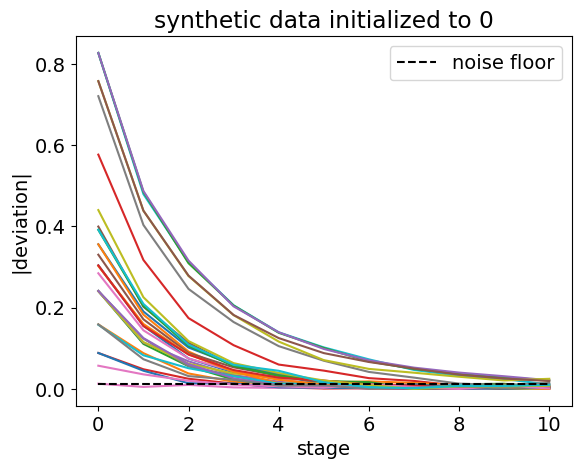

In [108]:
fig, ax = plt.subplots()
best_hs = jnp.asarray(oim.fit_h_to_empirical_means()) 
for i in range(len(best_hs)):
    label = f'{best_hs[i]}'
    label = None
    ax.plot(jnp.abs(re_h[:, i] - best_hs[i]), label=label) 
    # ax.plot(re_h[:, i])
    # ax.set_yscale('log') 

ax.hlines(mfloor, 0, 10, ls='--', color='black', label='noise floor')
ax.set_xlabel('stage')
ax.set_ylabel('|deviation|')
ax.legend()
ax.set_title('synthetic data initialized to 0') 
fig.savefig('tmp.png', bbox_inches='tight')

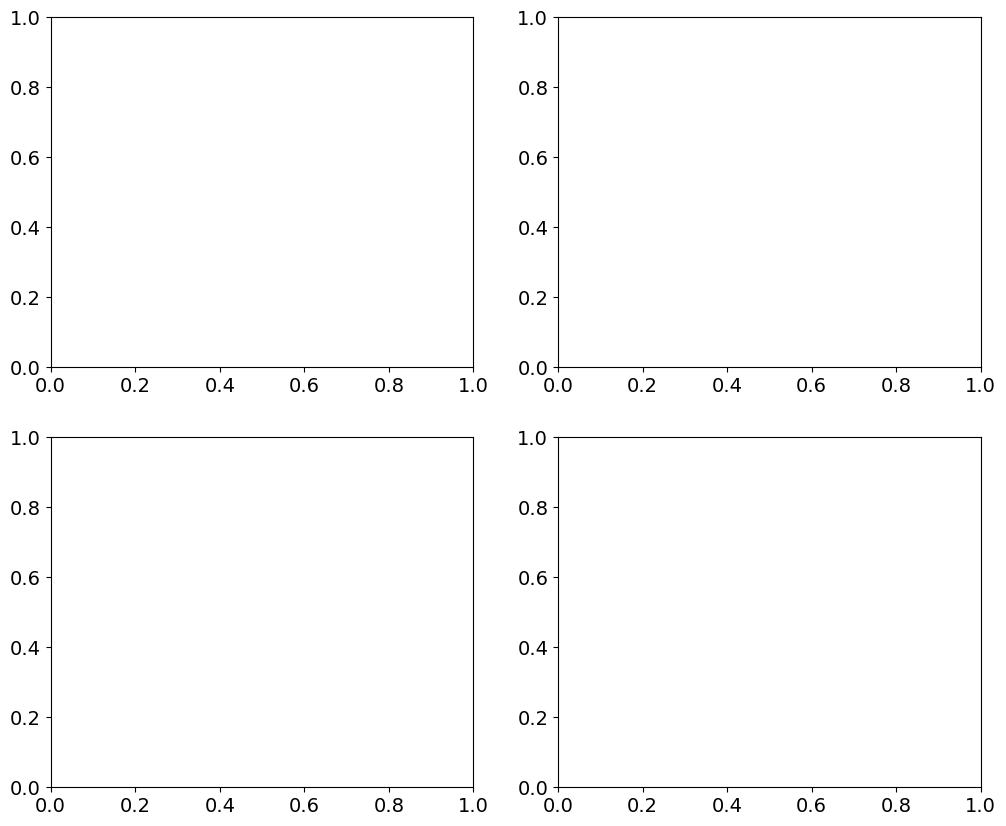

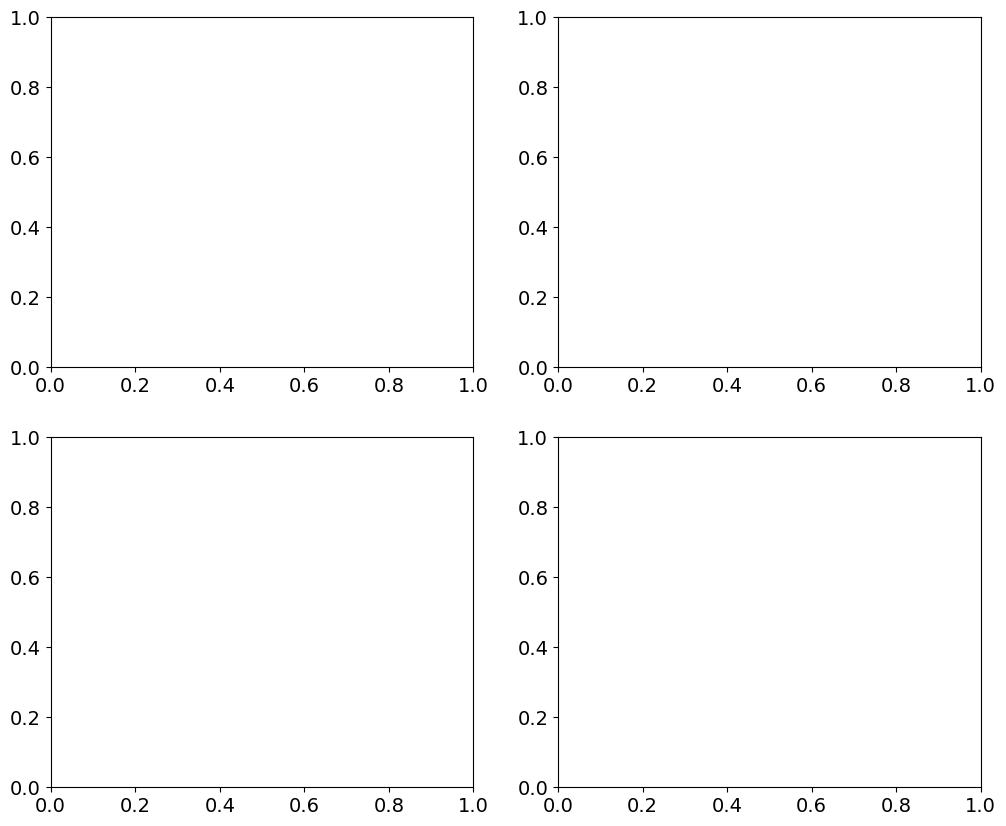

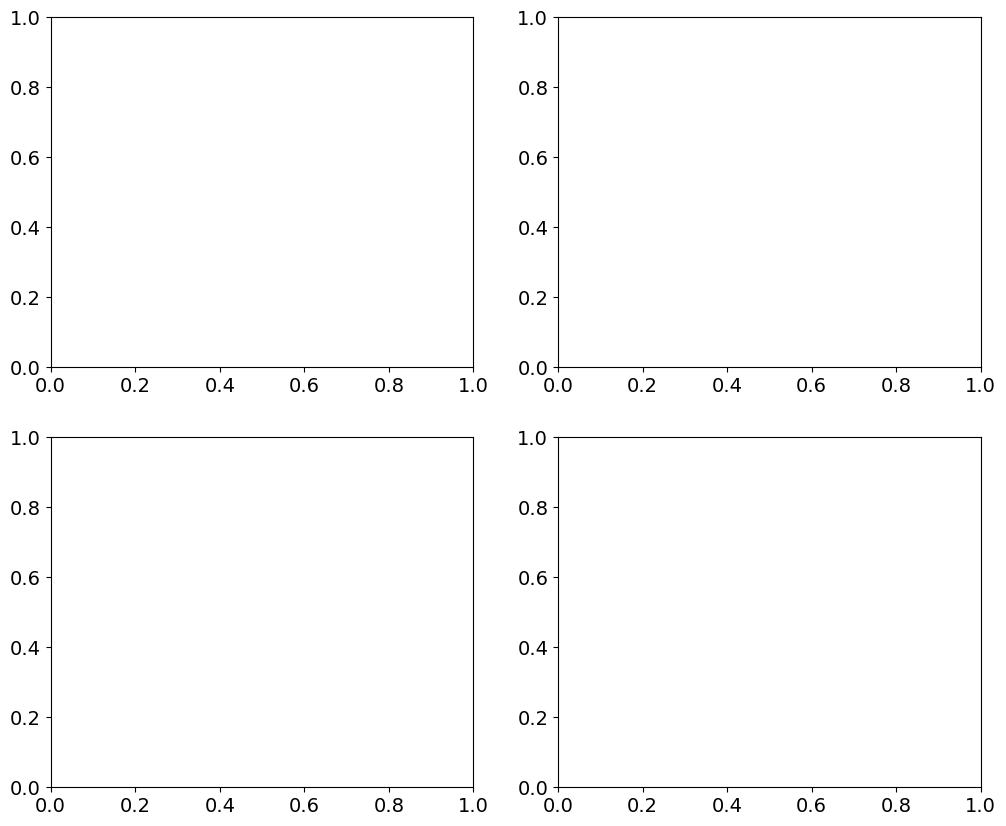

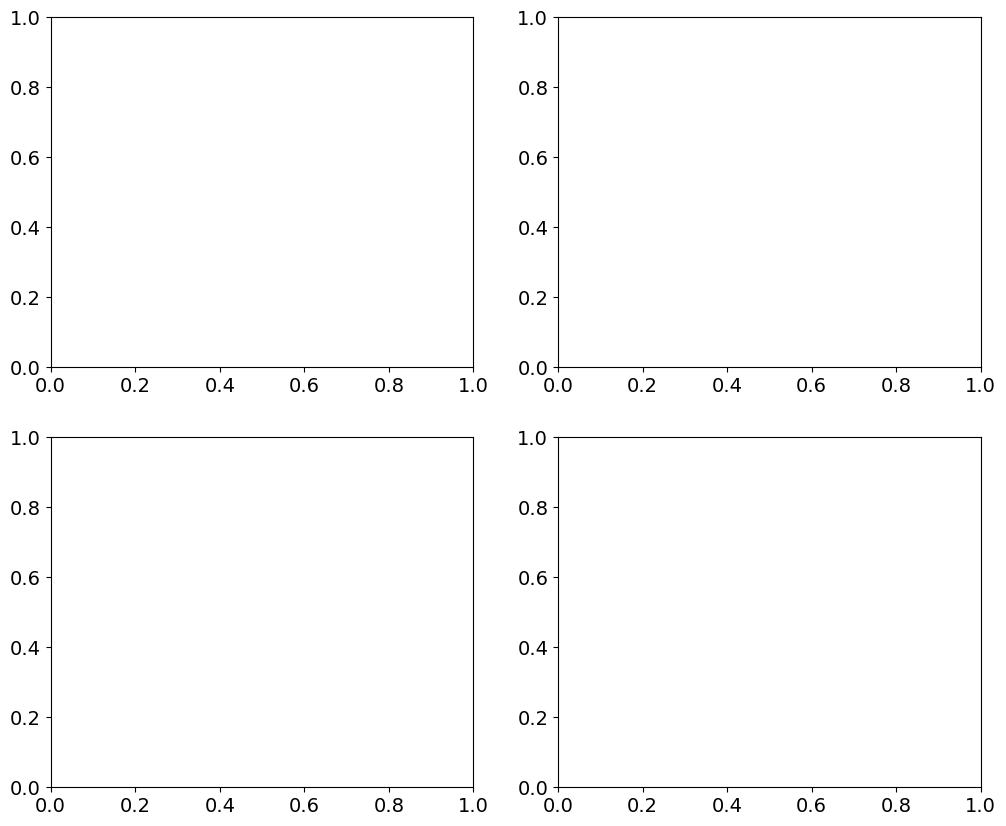

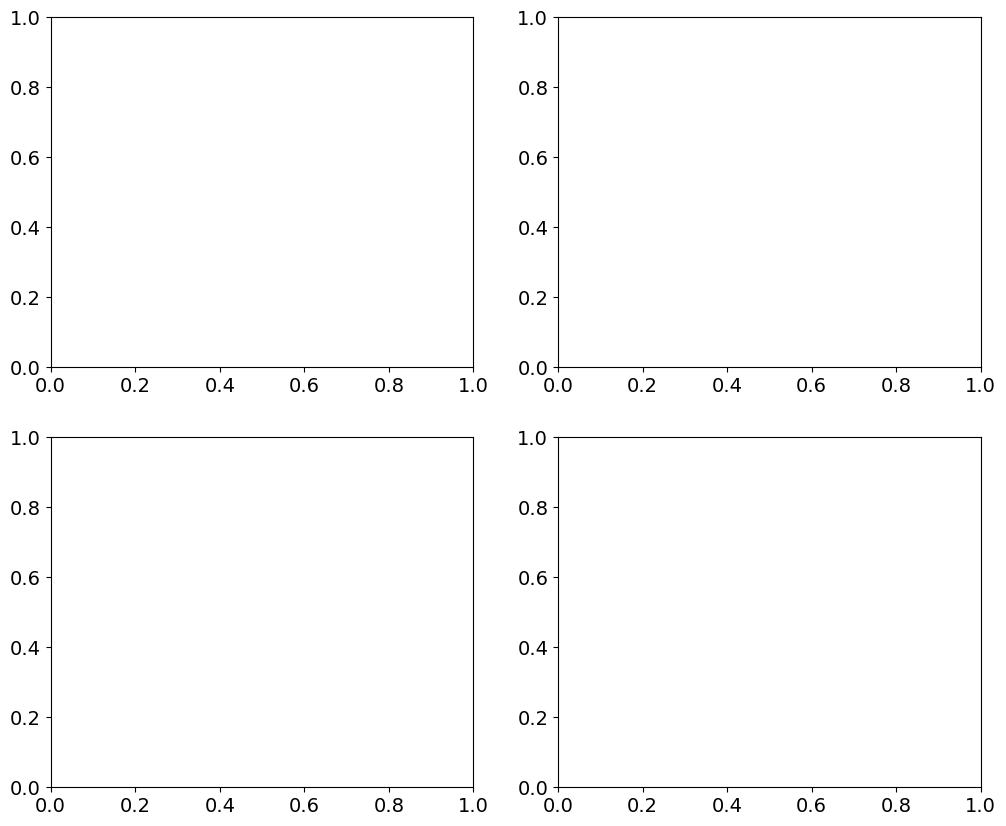

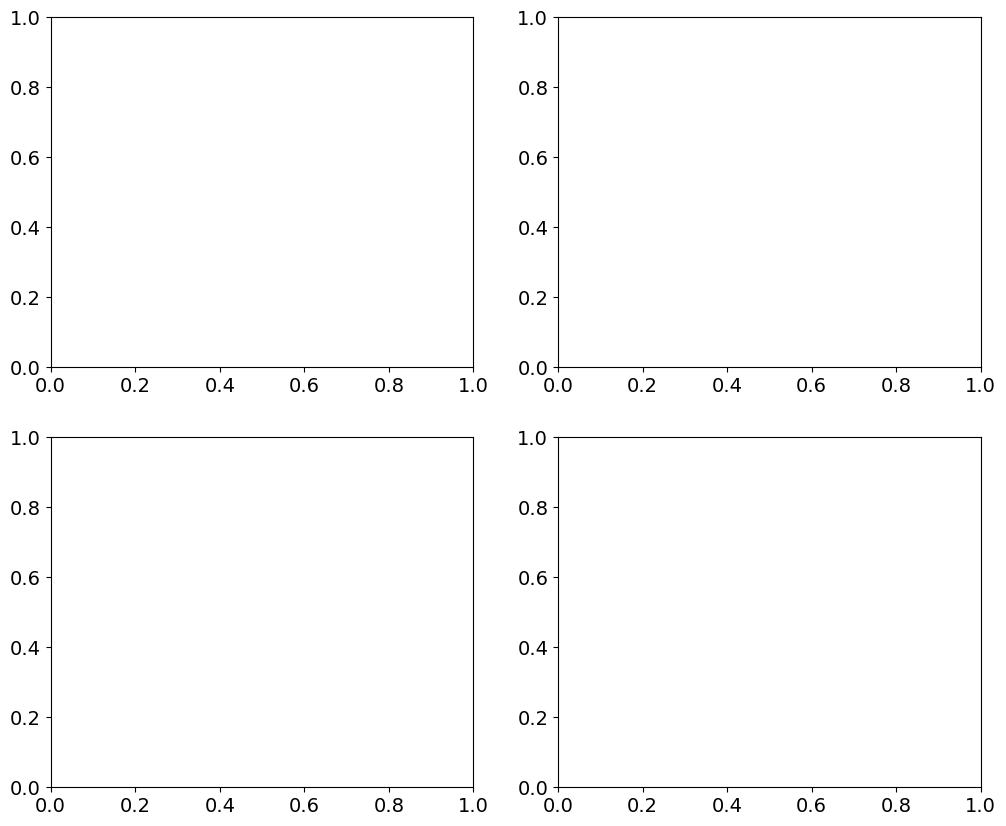

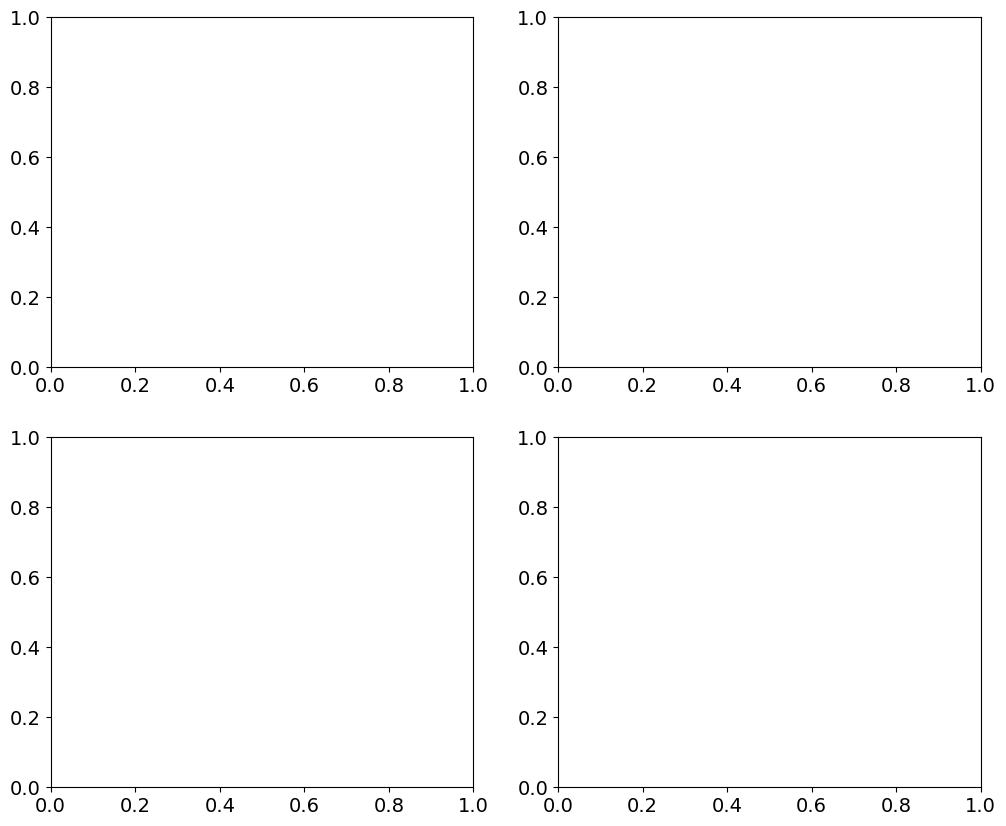

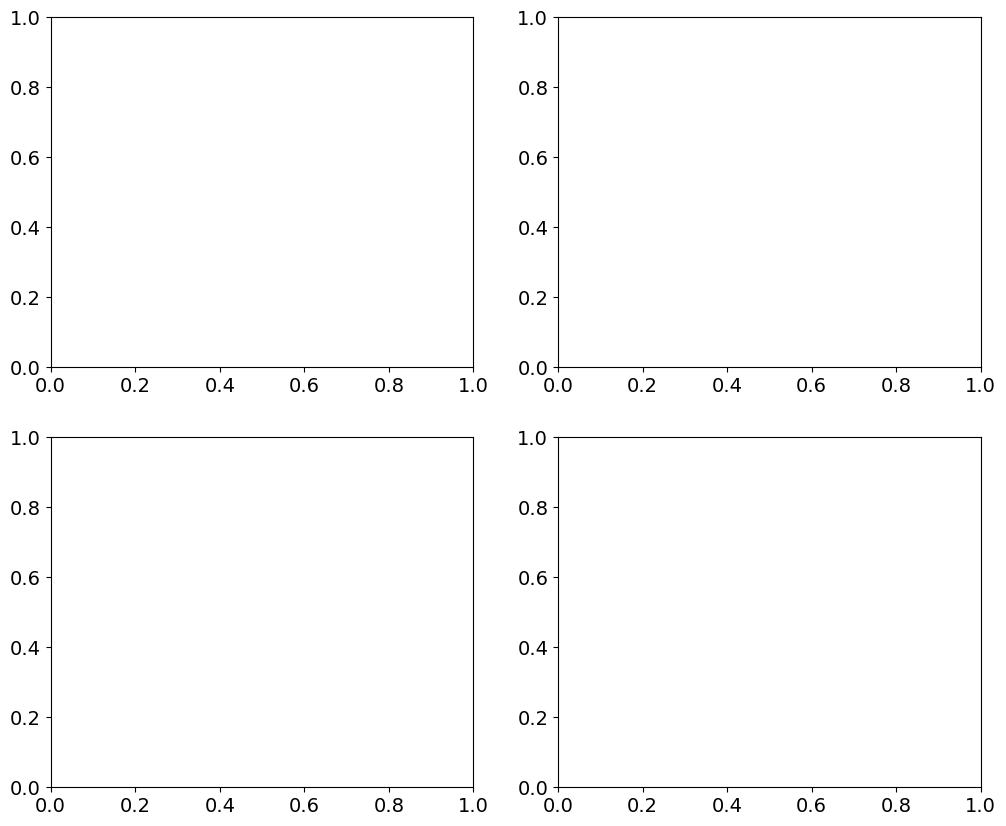

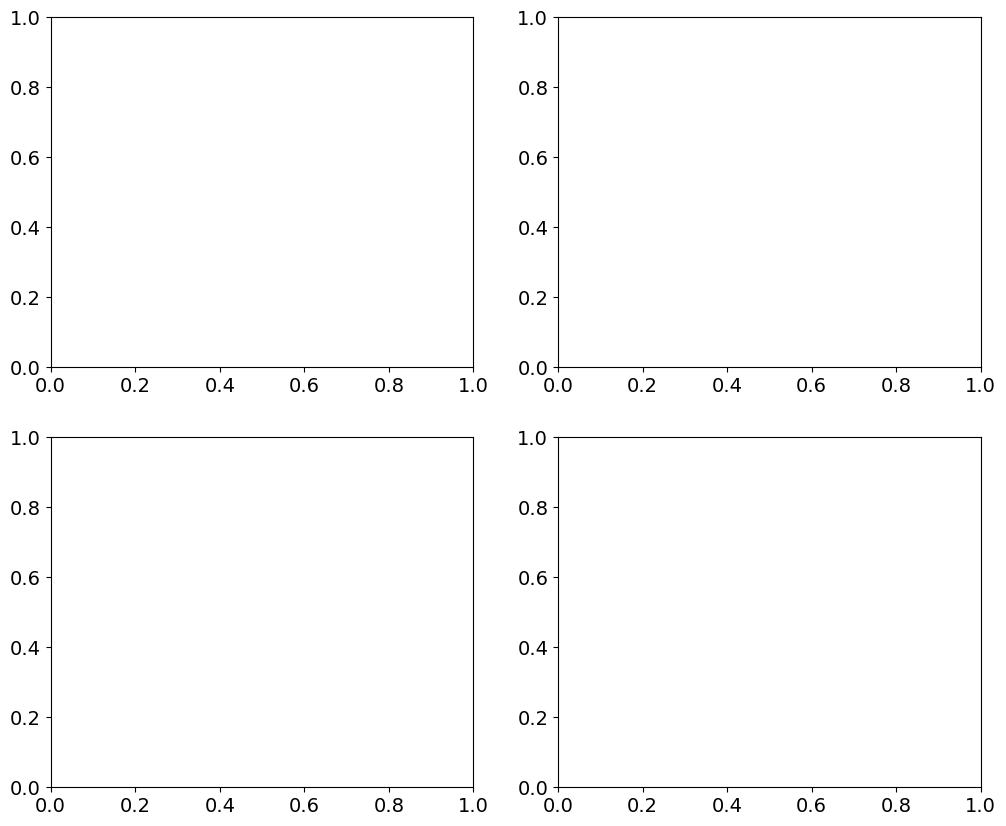

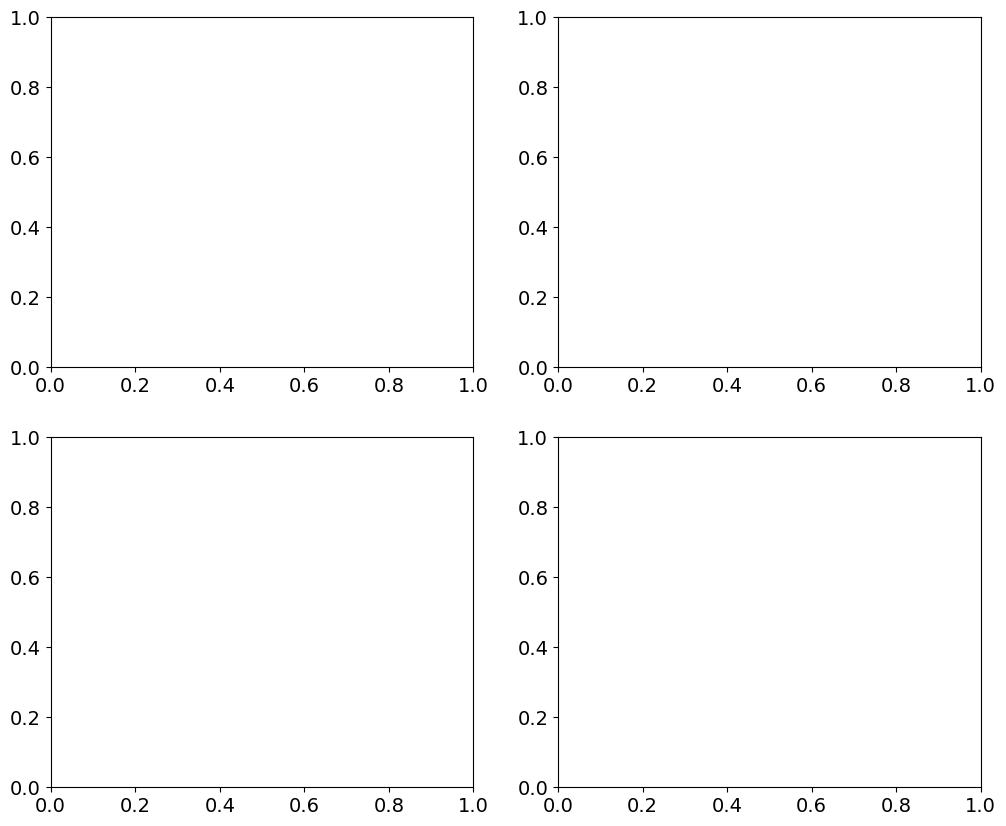

In [95]:
h_grads = jnp.zeros(re_h.shape)
J_grads = []
for i in range(re_h.shape[0]): 
    S = oim.generate_independent_samples(key, re_h[i], J, samples=1000) 
    _, _, grad_h, grad_J = oim.QC_samples(key, (S + 1) // 2, mode='None')
    h_grads = h_grads.at[i].set(grad_h) 

NameError: name 'h_grads' is not defined

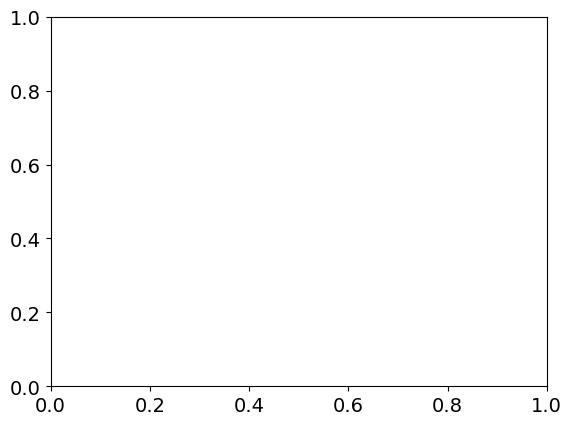

In [11]:
fig, ax = plt.subplots()
best_hs = oim.fit_h_to_empirical_means()
for i in range(87): 
    ax.plot(range(10), h_grads[:, i]) 

ax.set_yscale('log')

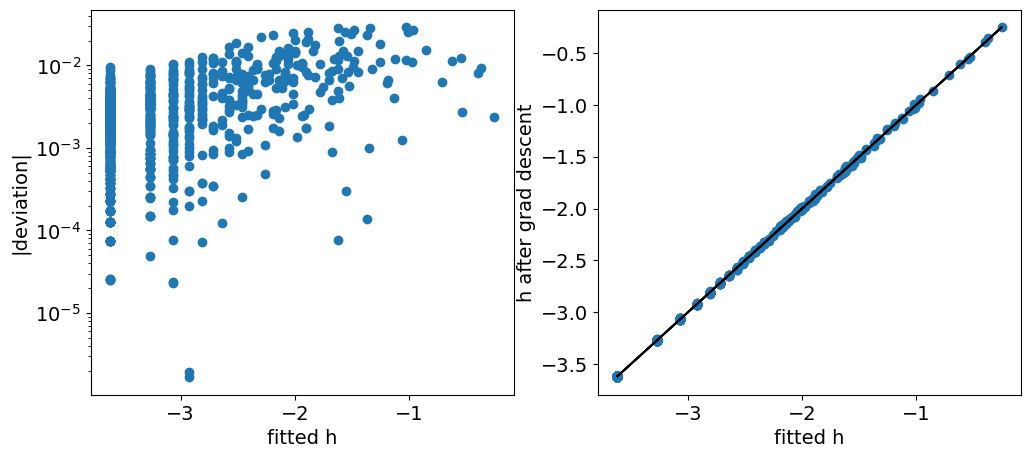

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(best_hs, jnp.abs(re_h[-1, :] - best_hs))
axs[0].set_yscale('log')
axs[1].scatter(best_hs, re_h[-1])
axs[1].plot(best_hs, best_hs, color='black') 
axs[0].set_xlabel('fitted h')
axs[0].set_ylabel('|deviation|') 
axs[1].set_xlabel('fitted h') 
axs[1].set_ylabel('h after grad descent')
fig.savefig('tmp.png')

In [71]:
h = oim.fit_h_to_empirical_means()

In [72]:
S = oim.generate_independent_samples(key, h, J, oim.data.shape[1] // 2)

In [77]:
m, c = oim.background_model_differences(key) 

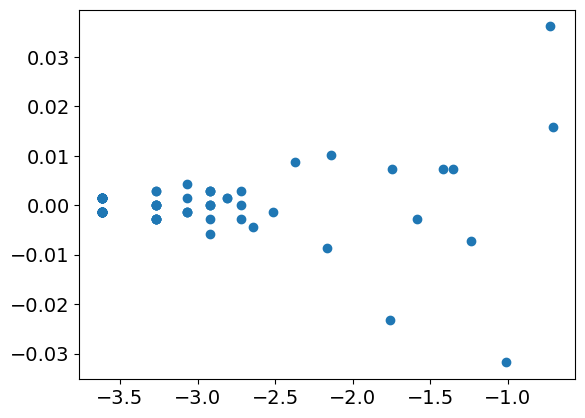

In [78]:
plt.scatter(h, m) 

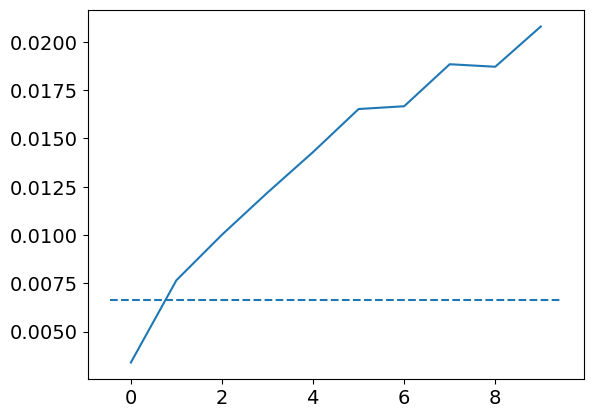

In [12]:
fig, ax = plt.subplots()
ax.plot(np.array(m))
# ax.plot(cs) 
bm, bc = oim.compute_background_average_deviations(key)
ax.hlines(jnp.abs(bm), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], ls='--', color='tab:blue') 
# ax.hlines(jnp.abs(bc), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], ls='--', color='tab:orange') 

In [16]:
synthetic = oim.generate_independent_samples(key, h, J, samples=oim.data.shape[1] // 2, burnin=20000, tau=2000)

In [18]:
oim.compute_average_deviations((synthetic + 1) // 2) 

(Array(-8.783204e-05, dtype=float32), Array(-0.00010051, dtype=float32))

In [11]:
# fig, axs = oim.QC_samples(key, (synthetic + 1) // 2, mode='hist')
axs[0, 0].set_title('mean deviations') 
axs[0, 0].set_ylabel('null model', fontsize=16) 
axs[0, 1].set_title('cov deviations') 
axs[1, 0].set_ylabel('synthetic vs real', fontsize=16)
axs[1, 1].set_yscale('log') 
axs[0, 1].set_yscale('log')
fig.suptitle('downsample at 0.1') 
fig.savefig('tmp.png')

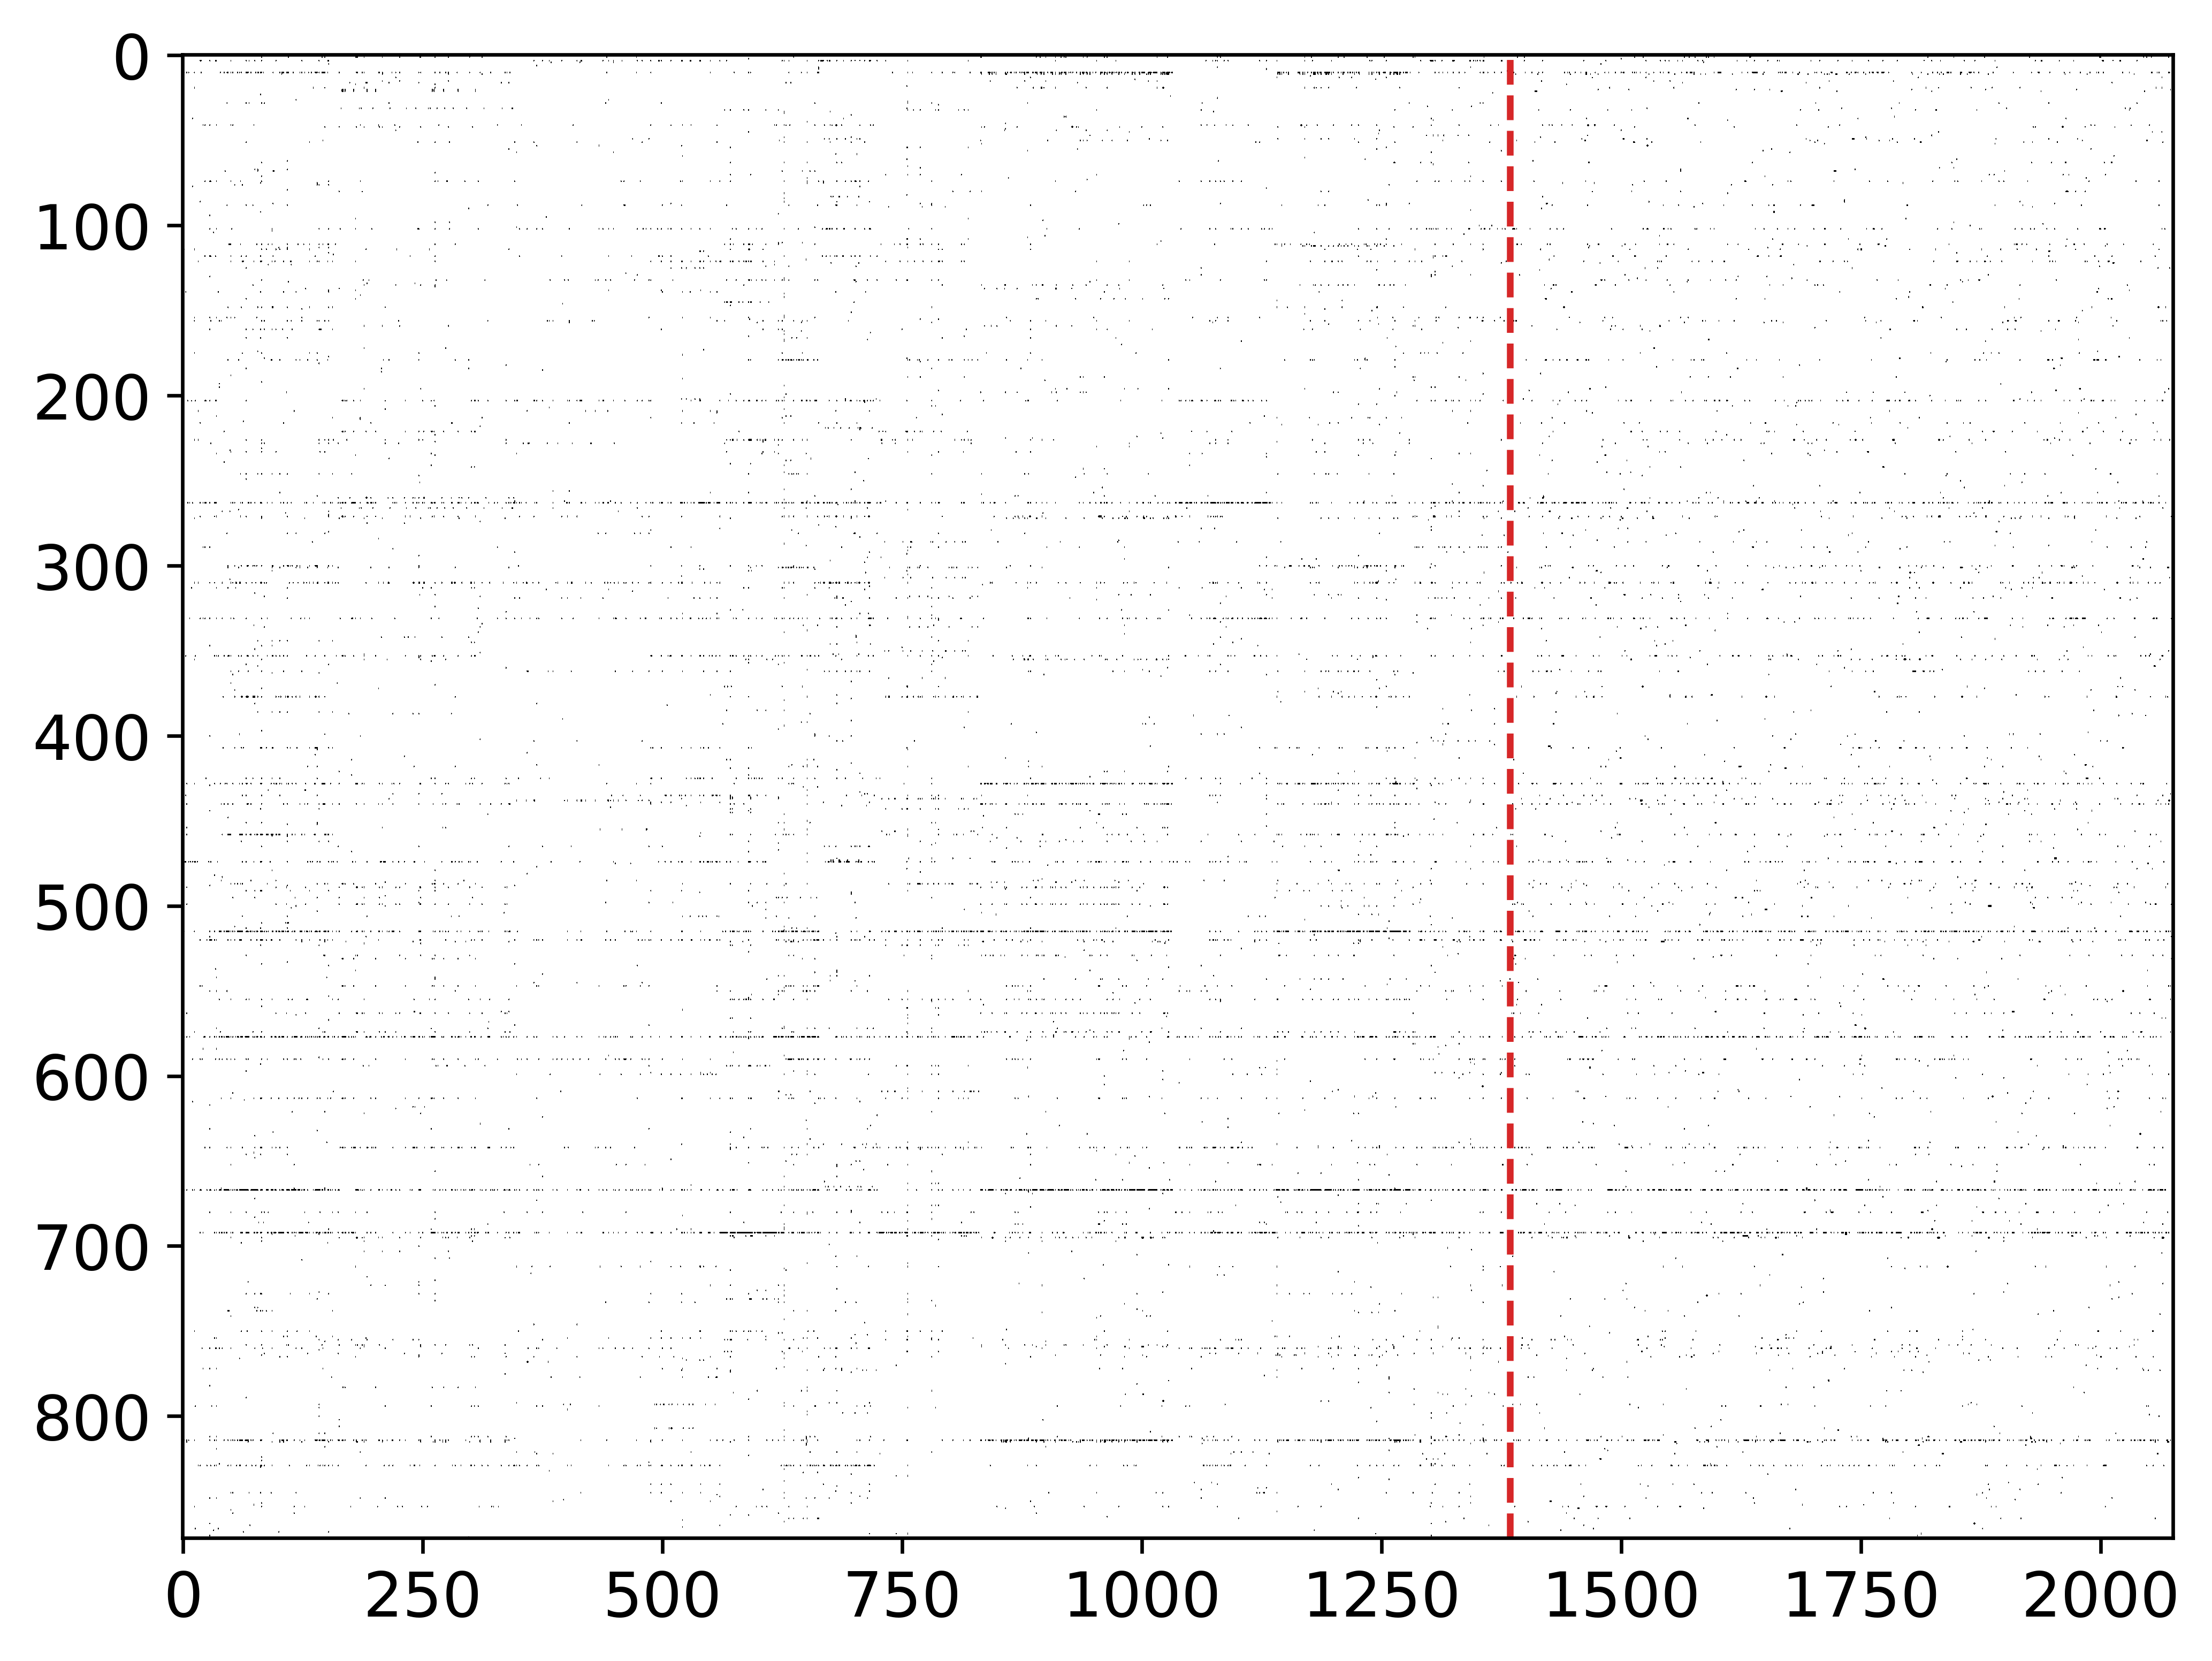

In [12]:
fig, ax = oim.plot_samples(jnp.concatenate([oim.data.values, (synthetic + 1) // 2], axis=1), window=1)
ax.vlines(oim.data.shape[1], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='tab:red', ls='--')

In [ ]:
mixed_data = jnp.concatenate([oim.data.values, (synthetic + 1)/2], axis=1)
oim.plot_samples(mixed_data, window=1)

Plot autocorrelation vs inverse temperature

In [13]:
betas = jnp.linspace(.001, .01, 50)
betas, taus = oim.tau_vs_beta(key, h, J, betas)
plt.scatter(betas, taus) 

Text(0, 0.5, '$\\langle M^2 \\rangle$')

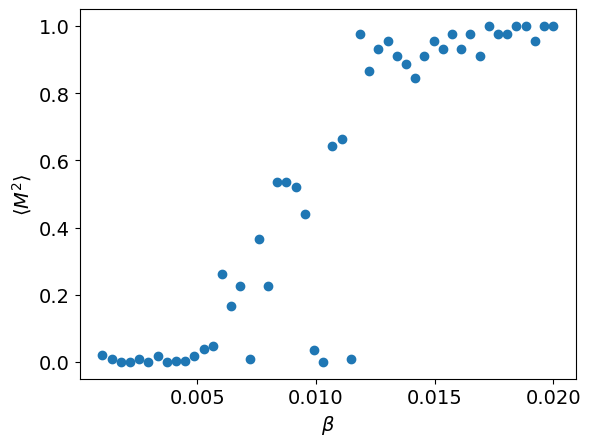

In [125]:
mags = []
for i, beta in enumerate(betas): 
    key = jax.random.PRNGKey(i)
    vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
    final_mag = 1 / vals.shape[0] * jnp.sum(vals[:, -1]) 
    mags.append(final_mag**2) 
fig, ax = plt.subplots()
ax.scatter(betas, mags)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle M^2 \rangle$')
# ax.set_xscale('log') 

In [126]:
vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=.002)

In [127]:
m = jnp.sum(vals, axis=0)

In [129]:
lags = [oim.autocorrelation(m, lag) for lag in range(1, 200)]

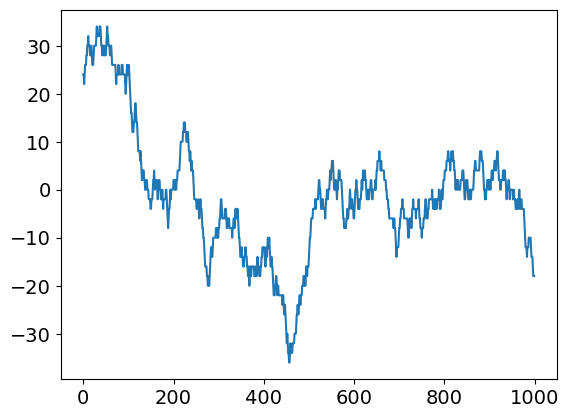

In [123]:
plt.plot(m) 

Text(0.5, 0, 'iteration')

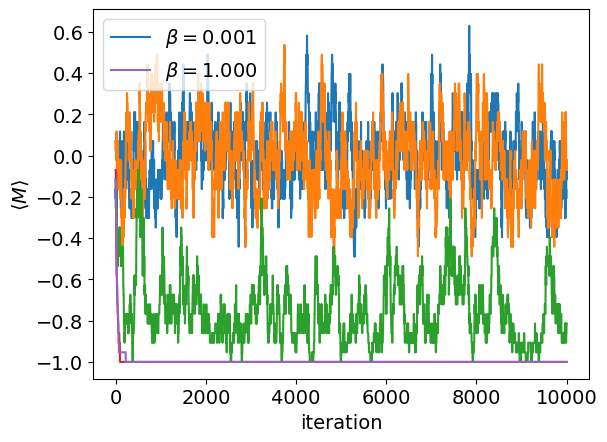

In [96]:
fig, ax = plt.subplots()

for i, beta in enumerate(betas): 
    key = jax.random.PRNGKey(i)
    vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
    if i == 0 or i == len(betas) - 1: 
        label = rf'$\beta = {beta:.3f}$'
    else: 
        label = ''
    ax.plot(1 / vals.shape[0] * vals.sum(axis=0), label=label) 
ax.legend() 
ax.set_ylabel(r'$\langle M \rangle$')
ax.set_xlabel('iteration')


In [39]:
vals = oim.sample_from_ising_model(key, h, J, iters=10000, beta=.03)

In [40]:
v = vals[:, 1000:]

In [41]:
m = jnp.sum(v, axis=0) 

In [42]:
lag = oim.estimate_autocorrelation_time(m) 

In [43]:
lag

145

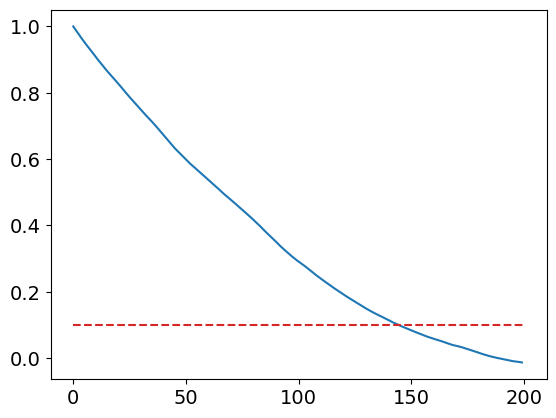

In [16]:
acs = [oim.autocorrelation(m, lag=l) for l in range(200)] 
plt.plot(range(200), acs)
plt.hlines(.1, 0, 200, ls='--', color='tab:red')

In [17]:
v.shape

(43, 9001)

In [269]:
v[:, ::150].shape

(43, 61)

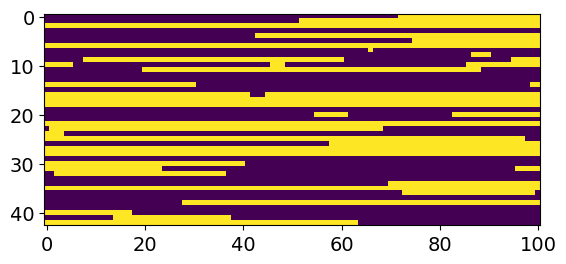

In [229]:
plt.imshow

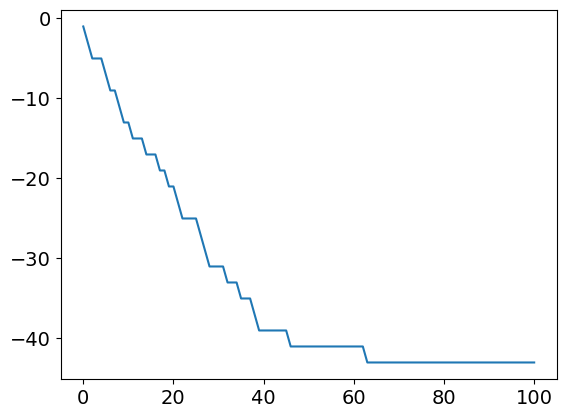

In [201]:
plt.plot(vals.sum(axis=0)[:])

In [24]:
cov = jnp.cov(oim.data.values) 

In [25]:
eig = jnp.linalg.eig(cov) 

In [29]:
10**-.3

0.5011872336272722

In [30]:
fractions = jnp.array([.01, .03, .1, .3, .5]) 

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/var/folders/qq/1ty9_n0n2rq91n4gcs0zkk440000gn/T/ipykernel_142/3485104052.py:6: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('Spectrum of $\hat{\Sigma}$')
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


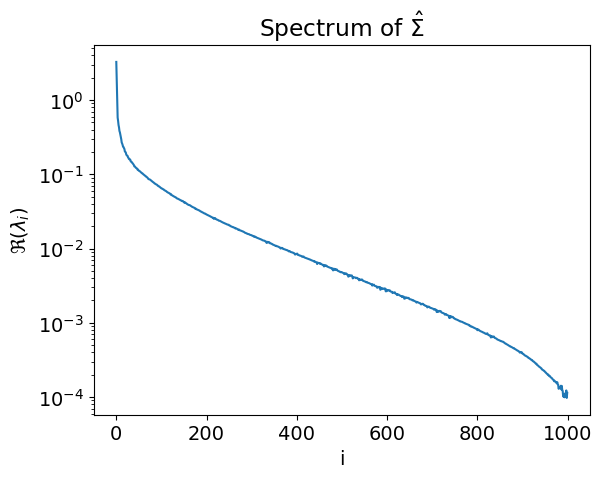

In [39]:
fig, ax = plt.subplots()
ax.plot(eig[0][:1000]) 
ax.set_yscale('log') 
ax.set_xlabel('i')
ax.set_ylabel(r'$\Re(\lambda_i)$')
ax.set_title('Spectrum of $\hat{\Sigma}$')
fig.savefig('eigenvalue_spectrum_50_percent_downsampled.png') 

0.01
0.03
0.1
0.3
0.5


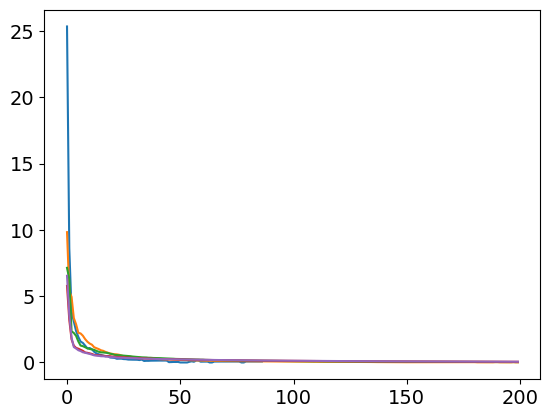

In [32]:
fig, ax = plt.subplots()
for frac in fractions: 
    print(frac) 
    oim.downsample_odorants(key, fraction=frac) 
    cov = jnp.cov(oim.data.values) 
    eig = jnp.linalg.eig(cov)
    ax.plot(jnp.real(eig[0][:200]) / frac) 

In [164]:
oim.subset_top_n_odorants(10)

,ALMOND_HULL_(mission)_10103.html,CHESTNUT_FLOWER_27470.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(raw)_27450.html,COCONUT_MILK_8330.html,GREEN_WALNUT_HUSK_(dried_unripe)(Juglans_regia_L.)_10840.html,MACADAMIA_NUT_(Macadamia_integrifolia)_(roasted)_10210.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(roasted)_27410.html,PISTACHIO_NUT_(Pistacia_vera)_(roasted)_19620.html,CHINESE_CHESTNUT_(Castanea_molissima)_(boiled)_27440.html,ALMOND_(roasted)_(Prunus_amygdalus)_10101.html,...,POTATO_(raw)_2510.html,BEANS_(raw)_9210.html,POTATO_(cooked_or_boiled)_2540.html,DEFATTED_SOYBEAN_8220.html,NOBIRU_(Allium_grayi_Regal)_2390.html,CABBAGE_(cooked)_1820.html,CHINESE_CABBAGE_21320.html,WELSH_ONION_(Allium_fistulosum_L._var._maichuon)_2392.html,RADISH_(raw)_12610.html,CHILI_PEPPER_PERICARP_(C._baccatum)_2625.html
&alpha;-terpineol (=p-1-menthen-8-ol),0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1-hexanol,1,0,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,0,1,0
1-pentanol (=amyl alcohol),0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
2-phenylethanol,1,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,0,0
3-methyl-1-butanol (=isoamyl alcohol),0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
benzaldehyde,1,1,0,0,0,1,1,0,0,1,...,1,1,1,0,0,1,0,0,0,0
hexanal,1,1,0,0,1,1,1,1,1,0,...,1,1,1,1,1,1,0,0,1,0
limonene,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
linalool,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
nonanal (=pelargonaldehyde),1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [162]:
oim.downsample_odorants(key) 

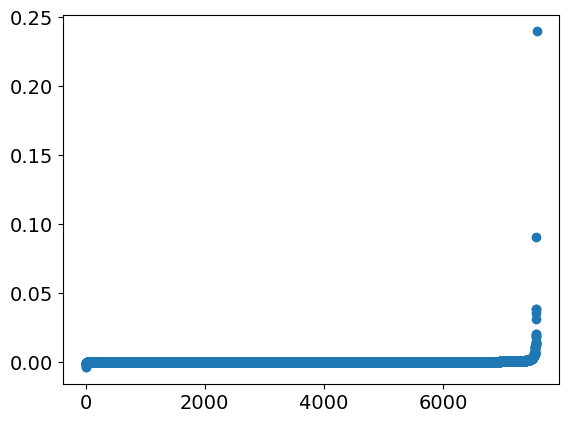

In [146]:
covs = jnp.cov(oim.data.values).flatten() 
plt.scatter(range(len(covs)), jnp.sort(covs))

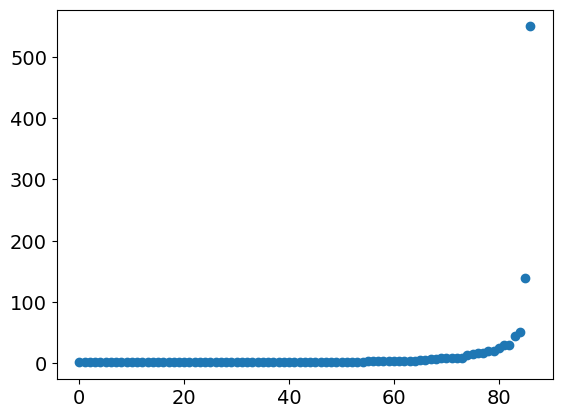

In [126]:
sums = jnp.sum(oim.data.values, axis=1) 
plt.scatter(range(len(sums)), jnp.sort(sums))

In [127]:
sums

Array([  1,   2,   1,   2,   1,   1,   1,  51,  14,   1,   3,   1,   1,
         1,   8,   1,   1,   3, 550,   1,   1,   1,   2,  29,   1,   5,
         1,   4,   1,   2,   3,   9,   1,   2,   1,   8,   1,  44,   4,
        19,   9,   2,   1,   1,   2,   3,   8,   1,   7,   5,   1,   1,
         1,   2,   1,   3,   1,   1,   1,  15,   4,   3,  19,   1,   1,
         2,  29,   1,   1,   1,   1,   1,   1,  25,   1, 139,  16,  17,
         2,   4,   1,   6,   1,   1,   1,   2,   1], dtype=int32)